In [2]:
import os
from functools import partial
from typing import (
  Tuple, List, Dict, Any, Sequence, Callable)

import haiku as hk
import jax
import jax.numpy as jnp
import jax.random as jr 
import jraph
import optax
import numpy as np
import matplotlib.pyplot as plt

from mnist_to_graphs import pad_graph_to_value

#### globals

In [3]:
Array = jnp.ndarray
Graph = jraph.GraphsTuple

N_GRAPHS = 2000
BATCH_SIZE = 16
N_STEPS = 5_000
PAD_VALUE = 8128 
F = 32
E = 32

#### data

In [4]:
def get_R_z_string(R_values, z_values, n_moments_calculate=3):
    if isinstance(R_values, list):
        if len(R_values) == len(all_R_values):
            R_string = "all"
        else:
            R_string = "_".join([str(float(R)) for R in R_values])
    else:
        R_string = str(R_values)
    if isinstance(z_values, list):
        if len(z_values) == len(all_redshifts):
            z_string = "all"
        else:
            z_string = "_".join([str(float(z)) for z in z_values])
    else:
        z_string = str(z_values)

    return f"x={resolution}_R={R_string}_z={z_string}_nm={n_moments_calculate}"

prng_seq = hk.PRNGSequence(0)

data_dir = "/Users/Jed.Homer/phd/lfi/jaxdelfi/data/"
resolution = 1024 
all_redshifts = [0., 0.5, 1., 2., 3.]
all_R_values = ["5.0", "10.0", "15.0", "20.0", "25.0", "30.0"]

redshifts = all_redshifts[:1]
R_values = all_R_values[:4]

R_idx = [all_R_values.index(R) for R in R_values]
z_idx = [redshifts.index(z) for z in redshifts]

print(f"Running for redshifts:\n{redshifts}\nat resolution x={resolution} with R values:\n{R_values}.")

Rz_string = get_R_z_string(R_values, redshifts, n_moments_calculate=3)

Running for redshifts:
[0.0]
at resolution x=1024 with R values:
['5.0', '10.0', '15.0', '20.0'].


#### data
* for each pdfs datavector, make fully connected subgraph for each redshift (EACH CUT FROM EACH REDSHIFT...), then concatenate all the redshift graphs together...

In [5]:
alpha = jnp.array([0.3175, 0.049, 0.6711, 0.9624, 0.834])
parameters = jnp.load(
        os.path.join(data_dir, f"ALL_PDFS_PARAMS.npy")) 
simulations = jnp.load(
    os.path.join(data_dir, f"latin_pdfs_cut_{Rz_string}.npy"))
simulations_mean = jnp.load(
    os.path.join(data_dir, f"latin_pdfs_cut_mean_{Rz_string}.npy"))
simulations_std = jnp.load(
    os.path.join(data_dir, f"latin_pdfs_cut_std_{Rz_string}.npy"))

fiducial_dv = jnp.load(
    os.path.join(data_dir, f"fiducial_pdfs_cut_{Rz_string}.npy"))
fiducial_dv = fiducial_dv.mean(axis=0)[jnp.newaxis, :]

n_sims, parameter_dim = parameters.shape
data_dim = np.prod(fiducial_dv.shape)

parameters.shape, simulations.shape, fiducial_dv.shape

((2000, 5), (2000, 151), (1, 151))

In [33]:
def make_subgraphs(moments):
    # Vmapping, so this is z-axis
    all_g_z = []
    for mz in moments:
        # print(mz.shape, np.prod(mz.shape))
        g_z = jraph.get_fully_connected_graph(
            node_features=mz.flatten(),
            n_node_per_graph=np.prod(mz.shape),
            n_graph=1,
            #global_features=parameters, # maybe just parameters for main_graph not subgraphs?
            add_self_edges=False)
        all_g_z.append(g_z)
    return all_g_z 


def make_graph_from_subgraphs(subgraphs, parameters):
    """ 
        Make ONE graph from fully connected redshift-subgraphs
        - NO connections between subgraphs of different redshift
    """
    return jraph.GraphsTuple(
        nodes=jnp.concatenate([g_z.nodes for g_z in subgraphs])[:, None],
        edges=None, # edges=jnp.concatenate([g_z.edges for g_z in subgraphs]), # edge FEATURES not senders/receivers
        # Since graph is made of subgraphs, need to re-index S and R for main_graph indexing...
        senders=jnp.concatenate(
            [g_z.n_node * n + g_z.senders for n, g_z in enumerate(subgraphs)]),# senders=jnp.concatenate([g_z.senders for g_z in subgraphs]),
        receivers=jnp.concatenate(
            [g_z.n_node * n + g_z.receivers for n, g_z in enumerate(subgraphs)]),# receivers=jnp.concatenate([g_z.receivers for g_z in subgraphs]),
        n_node=sum([g_z.n_node for g_z in subgraphs]),
        n_edge=sum([g_z.n_edge for g_z in subgraphs]),
        globals=parameters)#[None, :] if parameters.ndim == 1 else parameters)

In [34]:
subgraphs = make_subgraphs(fiducial_dv)
main_graph = make_graph_from_subgraphs(subgraphs, alpha)

(main_graph.nodes.shape, 
 main_graph.edges, 
 main_graph.globals, 
 main_graph.senders.shape, 
 main_graph.receivers.shape, 
 main_graph.globals.shape)

/Users/Jed.Homer/miniconda3/envs/jraph/lib/python3.10/site-packages/jraph/_src/utils.py:882: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  num_node_features = jax.tree_leaves(node_features)[0].shape[0]


((151, 1),
 None,
 DeviceArray([0.3175, 0.049 , 0.6711, 0.9624, 0.834 ], dtype=float32),
 (22650,),
 (22650,),
 (5,))

In [35]:
main_graph.senders.max()

DeviceArray(150, dtype=int32)

In [36]:
def adjacency_matrix(sender_indices, receiver_indices, n_nodes=None):
    # Determine the number of nodes in the graph if not provided
    if n_nodes is None:
        n_nodes = max(max(sender_indices), max(receiver_indices)) + 1

    # Create an empty adjacency matrix
    adj_matrix = np.zeros((n_nodes, n_nodes))

    # Set entries in the adjacency matrix for each edge
    for sender, receiver in zip(sender_indices, receiver_indices):
        adj_matrix[sender, receiver] = 1 
        adj_matrix[receiver, sender] = 1 

    return adj_matrix

In [37]:
attrs = ["nodes", "edges", "senders", "receivers", "globals", "n_node", "n_edge"]

for a in attrs:
    val = getattr(main_graph, a)
    print(a, val.shape if val is not None else None)

nodes (151, 1)
edges None
senders (22650,)
receivers (22650,)
globals (5,)
n_node (1,)
n_edge (1,)


[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]]


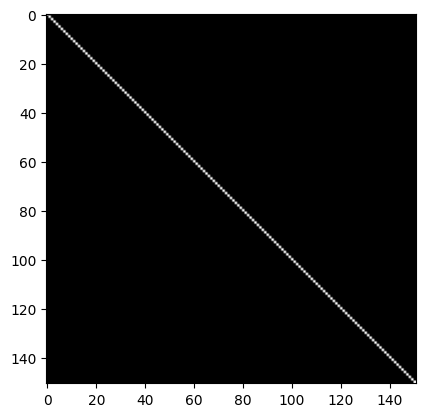

In [41]:
# Expect three squares on diagonal: FULLY connected subgraphs
A = adjacency_matrix(main_graph.senders, main_graph.receivers)
print(A)
plt.imshow(A, cmap="gray_r")
plt.show()

#### model

##### resnet

In [42]:
layernorm_kwargs = dict(axis=1, create_scale=True, create_offset=True)

class LinearResNet(hk.Module):
  def __init__(
    self, 
    hidden_sizes: Sequence[int],
    activation: Callable = jax.nn.leaky_relu,
    activate_final: bool = False):
    super().__init__()
    self.hidden_sizes = hidden_sizes
    self.activation = activation
    self.activate_final = activate_final

  def __call__(self, x):
    # assert x.shape[-1] == self.hidden_size, (
    #   "Input must be hidden size.")
    z = x
    for f in self.hidden_sizes:
      h = self.activation(z)
      h = hk.LayerNorm(**layernorm_kwargs)(h)
      h = hk.Linear(f)(h)
      h = self.activation(h)
      h = hk.LayerNorm(**layernorm_kwargs)(h)
      h = hk.Linear(f, w_init=jnp.zeros)(h)
      z = z + h 
    return self.activation(z) if self.activate_final else z

##### gnn

In [43]:
@jraph.concatenated_args
def edge_update_fn(feats: Array) -> Array:
  """ Edge update function for graph net. """
  net = hk.Sequential([
    hk.Linear(F), LinearResNet([F, F, F])])
    # hk.Linear(F), hk.nets.MLP([F, F, F])])
  return net(feats)

@jraph.concatenated_args 
def node_update_fn(feats: Array) -> Array:
  """ Node update function for graph net. """
  net = hk.Sequential([
    hk.Linear(F), LinearResNet([F, F, F])])
    # hk.Linear(F), hk.nets.MLP([F, F, F])])
  return net(feats)

@jraph.concatenated_args
def update_global_fn(feats: Array) -> Array:
  """ Global update function for graph net. """
  net = hk.Sequential([
    hk.Linear(F), 
    #LinearResNet([F, F, F], activate_final=True),
    hk.nets.MLP([F, F, F], activate_final=True),
    hk.Linear(parameter_dim, with_bias=True)]) # output summary of parameter dim
  return net(feats)

def LayerNormLinear(x):
    return hk.Linear(E, with_bias=False)(hk.LayerNorm(**layernorm_kwargs)(x))

def net_fn(graph: Graph) -> Graph:
  """ 
    Default aggregator functions for edges, global edges, global nodes 
    are "segment_sum"
  """
  embedder = jraph.GraphMapFeatures(
    # embed_edge_fn=LayerNormLinear, #hk.Linear(E, with_bias=False), 
    embed_node_fn=LayerNormLinear, #hk.Linear(E, with_bias=False), 
    embed_global_fn=LayerNormLinear) #hk.Linear(E, with_bias=False))
  net = jraph.GraphNetwork(
    update_node_fn=node_update_fn,
    # update_edge_fn=edge_update_fn,
    update_edge_fn=None,
    update_global_fn=update_global_fn)
  graph = embedder(graph)
#   for _ in range(3):
  graph = net(graph)
  return graph
  #return net(embedder(graph)) 

#### train

#### trainer functions

In [14]:
dataset_processed = []
for n in range(N_GRAPHS):
    l = parameters[n]
    g_z = make_subgraphs(simulations[n]) 
    g = make_graph_from_subgraphs(g_z, l[None, :]) # pointless 'l' here it is removed later anyway...
    dataset_processed.append(dict(input_graph=g, target=l))

In [17]:
g = dataset_processed[0]["input_graph"]
for a in attrs:
    val = getattr(g, a)
    print(a, val.shape if val is not None else None)

nodes (151, 1)
edges None
senders (151,)
receivers (151,)
globals (1, 5)
n_node (1,)
n_edge (1,)


In [18]:
gs, ls = [], []
for _ in range(5):
    gl = dataset_processed[_]
    g, l = gl.values()
    gs.append(g), ls.append(l)

g_all = jraph.batch(gs)
print([g.nodes.shape for g in gs])
g_all.nodes.shape
print(g_all.n_node)
print(g_all.n_edge)

for a in attrs:
    val = getattr(g_all, a)
    print(a, val.shape if val is not None else None)

[(151, 1), (151, 1), (151, 1), (151, 1), (151, 1)]
[151. 151. 151. 151. 151.]
[151 151 151 151 151]
nodes (755, 1)
edges None
senders (755,)
receivers (755,)
globals (5, 5)
n_node (5,)
n_edge (5,)


In [19]:
dataset_processed[0]["target"].shape

(5,)

In [20]:
def compute_loss(
  params: hk.Params, 
  graph: Graph, 
  label: Array,
  net: Graph) -> Tuple[Array, Array]:
  """Computes loss and accuracy."""

  pred_graph = net.apply(params, graph)
  print("pred graph globals", pred_graph.globals.shape)

  # Output of GNN and target: one hot encoded MNIST labels
  # preds = jax.nn.log_softmax(pred_graph.globals)
  preds = pred_graph.globals

  mask = jraph.get_graph_padding_mask(pred_graph)

  # Cross entropy loss.
  print("PREDS/TARGETS", preds.shape, label.shape)
  # loss = -(preds * label * mask[:, None]).mean()
  loss = (jnp.square(jnp.subtract(preds, label)) * mask[:, None]).mean()

  return loss, (None,)
 

def train(
  dataset: List[Dict[str, Any]], 
  num_train_steps: int) -> Tuple[hk.Params, List, List]:

  key = jr.PRNGKey(0)

  net = hk.without_apply_rng(hk.transform(net_fn))

  graph = dataset[0]['input_graph']
  graph = pad_graph_to_value(graph, PAD_VALUE)
  params = net.init(key, graph)

  print(f"n_params = {sum(x.size for x in jax.tree_util.tree_leaves(params)):.2E}")

  # Initialize the optimizer.
  opt_init, opt_update = optax.adabelief(2e-4)
  opt_state = opt_init(params)

  compute_loss_fn = partial(compute_loss, net=net)
  compute_loss_fn = jax.jit(
    jax.value_and_grad(compute_loss_fn, has_aux=True))

  losses, accs = [], []
  for s in range(num_train_steps):
    key, key_idx = jr.split(key)

    if BATCH_SIZE > 1:
        idx = jr.randint(key_idx, shape=(BATCH_SIZE,), minval=0, maxval=N_GRAPHS)
        gs, ls = [], []
        for i in idx:
            g, l = dataset[int(i)].values()
            gs.append(g), ls.append(l)
        graph = jraph.batch(gs)
        label = jnp.stack(ls)
    else:
        idx = int(jr.randint(key_idx, shape=(BATCH_SIZE,), minval=0, maxval=N_GRAPHS))
        graph, label = dataset[idx].values()

    """ Should remove graph label, for model to generate itself. """
    # graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))
    graph = pad_graph_to_value(graph, PAD_VALUE)

    # Since padding is implemented with pad_with_graphs, an extra graph has
    # been added to the batch, which means there should be an extra label.
    """ This label gets masked out. """
    label = jnp.concatenate([label, jnp.zeros((1, parameter_dim))])

    (loss, (_)), grad = compute_loss_fn(params, graph, label)
    updates, opt_state = opt_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)

    if s % 100 == 0:
      print(f'\rstep: {s:06d}, loss: {loss:.4f}', end="")
    losses.append(loss)

  print('Training finished')
  return params, losses, accs

#### check

In [21]:
print([_.shape for _ in g_all if _ is not None])

[(755, 1), (755,), (755,), (5, 5), (5,), (5,)]


In [22]:
key = jr.PRNGKey(0)
key, _ = jr.split(key)

net = hk.without_apply_rng(hk.transform(net_fn))

graph = pad_graph_to_value(g_all, PAD_VALUE)
print(graph.globals, graph.globals.shape)

params = net.init(key, g_all)

y_ = net.apply(params, g_all)
print("net out", y_.globals.shape)

mask = jraph.get_graph_padding_mask(y_)
print(mask)

jnp.argmax(y_.globals[mask], axis=1), l.argmax()

[[0.1755  0.06681 0.7737  0.8849  0.6641 ]
 [0.2139  0.05557 0.8599  0.9785  0.8619 ]
 [0.1867  0.04503 0.6189  0.8307  0.7187 ]
 [0.3271  0.06875 0.6313  0.8135  0.8939 ]
 [0.1433  0.06347 0.6127  1.1501  0.7699 ]
 [0.      0.      0.      0.      0.     ]] (6, 5)


TypeError: Indexer must have integer or boolean type, got indexer with type float32 at position 0, indexer value [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 197. 198. 199. 200. 201. 202. 203. 204. 205. 206. 207. 208. 209.
 210. 211. 212. 213. 214. 215. 216. 217. 218. 219. 220. 221. 222. 223.
 224. 225. 226. 227. 228. 229. 230. 231. 232. 233. 234. 235. 236. 237.
 238. 239. 240. 241. 242. 243. 244. 245. 246. 247. 248. 249. 250. 251.
 252. 253. 254. 255. 256. 257. 258. 259. 260. 261. 262. 263. 264. 265.
 266. 267. 268. 269. 270. 271. 272. 273. 274. 275. 276. 277. 278. 279.
 280. 281. 282. 283. 284. 285. 286. 287. 288. 289. 290. 291. 292. 293.
 294. 295. 296. 297. 298. 299. 300. 301. 302. 303. 304. 305. 306. 307.
 308. 309. 310. 311. 312. 313. 314. 315. 316. 317. 318. 319. 320. 321.
 322. 323. 324. 325. 326. 327. 328. 329. 330. 331. 332. 333. 334. 335.
 336. 337. 338. 339. 340. 341. 342. 343. 344. 345. 346. 347. 348. 349.
 350. 351. 352. 353. 354. 355. 356. 357. 358. 359. 360. 361. 362. 363.
 364. 365. 366. 367. 368. 369. 370. 371. 372. 373. 374. 375. 376. 377.
 378. 379. 380. 381. 382. 383. 384. 385. 386. 387. 388. 389. 390. 391.
 392. 393. 394. 395. 396. 397. 398. 399. 400. 401. 402. 403. 404. 405.
 406. 407. 408. 409. 410. 411. 412. 413. 414. 415. 416. 417. 418. 419.
 420. 421. 422. 423. 424. 425. 426. 427. 428. 429. 430. 431. 432. 433.
 434. 435. 436. 437. 438. 439. 440. 441. 442. 443. 444. 445. 446. 447.
 448. 449. 450. 451. 452. 453. 454. 455. 456. 457. 458. 459. 460. 461.
 462. 463. 464. 465. 466. 467. 468. 469. 470. 471. 472. 473. 474. 475.
 476. 477. 478. 479. 480. 481. 482. 483. 484. 485. 486. 487. 488. 489.
 490. 491. 492. 493. 494. 495. 496. 497. 498. 499. 500. 501. 502. 503.
 504. 505. 506. 507. 508. 509. 510. 511. 512. 513. 514. 515. 516. 517.
 518. 519. 520. 521. 522. 523. 524. 525. 526. 527. 528. 529. 530. 531.
 532. 533. 534. 535. 536. 537. 538. 539. 540. 541. 542. 543. 544. 545.
 546. 547. 548. 549. 550. 551. 552. 553. 554. 555. 556. 557. 558. 559.
 560. 561. 562. 563. 564. 565. 566. 567. 568. 569. 570. 571. 572. 573.
 574. 575. 576. 577. 578. 579. 580. 581. 582. 583. 584. 585. 586. 587.
 588. 589. 590. 591. 592. 593. 594. 595. 596. 597. 598. 599. 600. 601.
 602. 603. 604. 605. 606. 607. 608. 609. 610. 611. 612. 613. 614. 615.
 616. 617. 618. 619. 620. 621. 622. 623. 624. 625. 626. 627. 628. 629.
 630. 631. 632. 633. 634. 635. 636. 637. 638. 639. 640. 641. 642. 643.
 644. 645. 646. 647. 648. 649. 650. 651. 652. 653. 654. 655. 656. 657.
 658. 659. 660. 661. 662. 663. 664. 665. 666. 667. 668. 669. 670. 671.
 672. 673. 674. 675. 676. 677. 678. 679. 680. 681. 682. 683. 684. 685.
 686. 687. 688. 689. 690. 691. 692. 693. 694. 695. 696. 697. 698. 699.
 700. 701. 702. 703. 704. 705. 706. 707. 708. 709. 710. 711. 712. 713.
 714. 715. 716. 717. 718. 719. 720. 721. 722. 723. 724. 725. 726. 727.
 728. 729. 730. 731. 732. 733. 734. 735. 736. 737. 738. 739. 740. 741.
 742. 743. 744. 745. 746. 747. 748. 749. 750. 751. 752. 753. 754.]

In [23]:
key = jr.PRNGKey(0)
key, _ = jr.split(key)

net = hk.without_apply_rng(hk.transform(net_fn))

ix1, ix2 = jr.randint(key, (2,), 0, len(dataset_processed))

graph = dataset_processed[ix1]['input_graph']
l = dataset_processed[ix1]['target']
graph = pad_graph_to_value(graph, PAD_VALUE)
print(graph.globals, graph.globals.shape)

for a in attrs:
    val = getattr(graph, a)
    print(a, val.shape if val is not None else None)

params = net.init(key, graph)

graph = dataset_processed[ix2]['input_graph']
l = dataset_processed[ix2]['target']
graph = pad_graph_to_value(graph, PAD_VALUE)

y_ = net.apply(params, graph)
print("net out", y_.globals.shape)

mask = jraph.get_graph_padding_mask(y_)
print(mask)

jnp.argmax(y_.globals[mask], axis=1), l.argmax()

[[0.2497  0.06921 0.8915  1.0937  0.6587 ]
 [0.      0.      0.      0.      0.     ]] (2, 5)
nodes (8129, 1)
edges None
senders (8128,)
receivers (8128,)
globals (2, 5)
n_node (2,)
n_edge (2,)


TypeError: Indexer must have integer or boolean type, got indexer with type float32 at position 0, indexer value [  0.   1.   2. ... 151. 151. 151.]

In [56]:
graph = dataset_processed[ix2]['input_graph']
print("before pad", graph.nodes.shape, graph.globals.shape)
l = dataset_processed[ix2]['target']
graph = pad_graph_to_value(graph, PAD_VALUE)
print("after pad", graph.nodes.shape, graph.globals.shape)

before pad (36, 1) (1, 5)
after pad (8129, 1) (2, 5)


In [57]:
params, losses, accs = train(dataset_processed, num_train_steps=N_STEPS)

n_params = 1.44E+04
pred graph globals (17, 5)
PREDS/TARGETS (17, 5) (17, 5)
step: 004900, loss: 0.0019Training finished


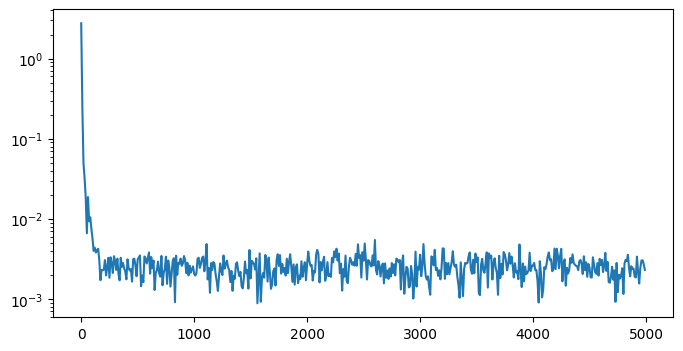

In [58]:
fig, ax = plt.subplots(1, 1, dpi=100, figsize=(8.,4.))
steps = range(0, N_STEPS, 10)
ax.semilogy(steps, losses[::10])
plt.show()

In [59]:
graphs = []
for gl in dataset_processed:
    g, l = gl.values()
    graphs.append(g)

all_graphs = jraph.batch(graphs)
for a in attrs:
    val = getattr(all_graphs, a)
    print(a, val.shape if val is not None else None)

nodes (72000, 1)
edges None
senders (864000,)
receivers (864000,)
globals (2000, 5)
n_node (2000,)
n_edge (2000,)


In [60]:
fiducial_subgraphs = make_subgraphs(fiducial_dv)
fiducial_graph = make_graph_from_subgraphs(fiducial_subgraphs, alpha[None, :])

In [61]:
all_graphs_out = net.apply(params, all_graphs)
fiducial_graph_out = net.apply(params, fiducial_graph)
preds = all_graphs_out.globals
fiducial_preds = fiducial_graph_out.globals
fiducial_preds.shape 

(1, 5)

In [62]:
# List of graphs
unbatched_graphs = jraph.unbatch(all_graphs_out)
isinstance(unbatched_graphs, list)

senders and receivers are constant through application of graph interaction network

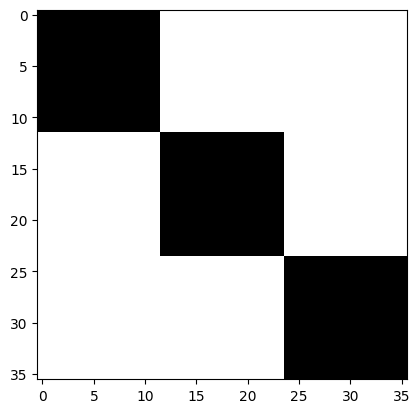

In [ ]:
A = adjacency_matrix(unbatched_graphs[0].senders, unbatched_graphs[0].receivers)
plt.imshow(A, cmap="gray_r")
plt.show()

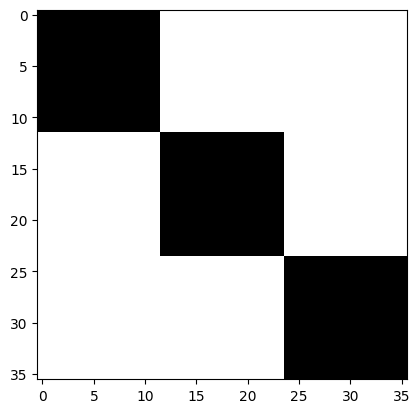

In [ ]:
A = adjacency_matrix(fiducial_graph_out.senders, fiducial_graph_out.receivers)
plt.imshow(A, cmap="gray_r")
plt.show()

(2000, 2) (2000, 2)


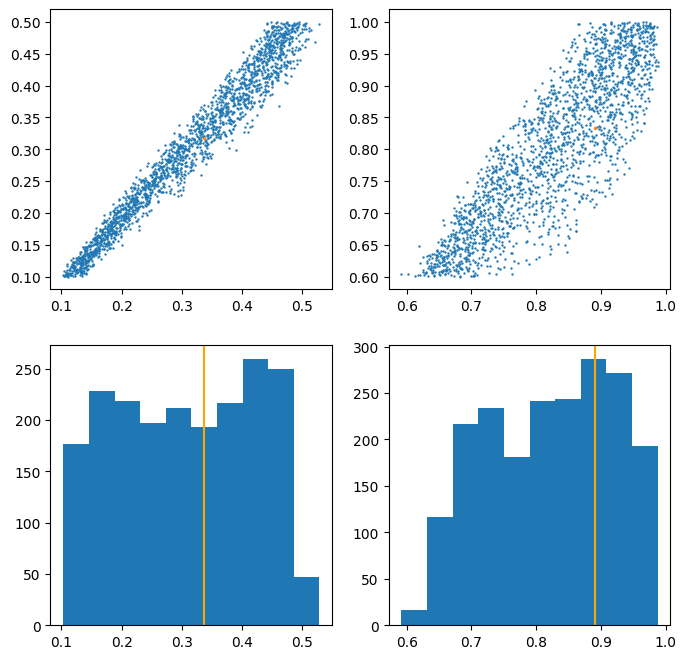

In [ ]:
target_idx = jnp.array([0, 4])
pred_targets = preds[:, target_idx]
parameter_targets = parameters[:N_GRAPHS, target_idx]

print(pred_targets.shape, parameter_targets.shape)

fig, axs = plt.subplots(2, 2, figsize=(8., 8.), dpi=100)
ax = axs[0, 0]

ax.scatter(pred_targets[:, 0], parameter_targets[:, 0], s=0.5)
ax.scatter(fiducial_preds[:, 0], alpha[None, :][:, 0], s=2.)
ax = axs[0, 1]
ax.scatter(pred_targets[:, 1], parameter_targets[:, 1], s=0.5)
ax.scatter(fiducial_preds[:, 4], alpha[None, :][:, 4], s=2.)
ax = axs[1, 0]
ax.hist(pred_targets[:, 0])
ax.axvline(fiducial_preds[:, 0], color="orange")
ax = axs[1, 1]
ax.hist(pred_targets[:, 1])
ax.axvline(fiducial_preds[:, 4], color="orange")
plt.show()

In [ ]:
fiducial_preds.shape

(1, 5)

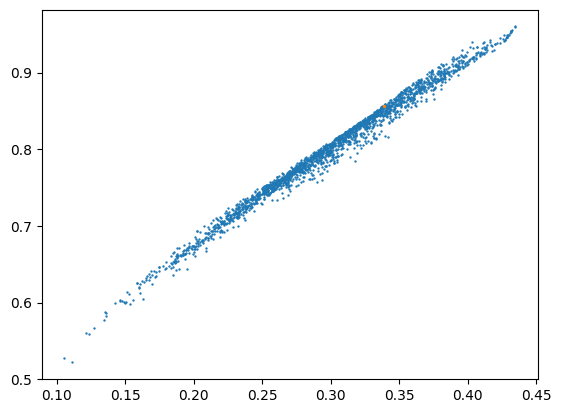

In [ ]:
plt.figure()
plt.scatter(*pred_targets.T, s=0.5)
plt.scatter(*fiducial_preds[:, target_idx].T, s=2.)
plt.show()